# 신천 영향권 데이터 전처리

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPoint

In [3]:
#신천 영향권 데이터 gdf로 만들기
L_name=['node5', 'node10', 'node15', 'node20', 'node25']
L_time = [5, 10, 15, 20, 25]

final_df = pd.DataFrame()

for i in range(5) :
    
    name=L_name[i]
    df_name = './node_csv/' + name + '_4326.csv'
    df = pd.read_csv(df_name)
    df = gpd.GeoDataFrame(df)

    df['lon'] = df['lon'].astype(float)
    df['lat'] = df['lat'].astype(float)
    
    df['geometry'] = df.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
    df = gpd.GeoDataFrame(df[['osmid', 'color', 'street_cou', 'geometry']], geometry='geometry', crs = 'epsg:4326')
    
    #추출된 df의 점들로 폴리곤 생성, 경계값만 가져와서 저장
    poly = Polygon(Polygon(MultiPoint([[p.x, p.y] for p in df.geometry]).convex_hull).exterior)
    
    #특정 색상값이 나타내는 시간
    time = L_time[i]
    
    #전체 통합
    final_df = final_df.append(pd.DataFrame([name, time, poly]).T, ignore_index=True)
    

final_df.columns=['node_id', 'time', 'geometry']
final_gdf = gpd.GeoDataFrame(final_df, geometry='geometry', crs='epsg:4326')
final_gdf

c:\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16280\2154104161.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(pd.DataFrame([name, time, poly]).T, ignore_index=True)
c:\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16280\2154104161.py:27: FutureWarning: The frame.append method is deprecated and will

,node_id,time,geometry
0,node5,5,"POLYGON ((128.62498 35.80213, 128.62228 35.802..."
1,node10,10,"POLYGON ((128.62248 35.80107, 128.60983 35.809..."
2,node15,15,"POLYGON ((128.62488 35.79781, 128.62369 35.798..."
3,node20,20,"POLYGON ((128.62801 35.79490, 128.60568 35.805..."
4,node25,25,"POLYGON ((128.62859 35.79305, 128.60153 35.810..."


In [4]:
final_gdf['unique_geometry'] = ''

for i in range(5) :
    bigPoly = final_gdf.loc[i, 'geometry']

    if i == 0 :
        poly = bigPoly
        final_gdf.at[i, 'unique_geometry'] = poly   #5분거리 폴리곤은 그대로 두고
    else :
        smallPoly = final_gdf.loc[i-1, 'geometry']
        poly = bigPoly.difference(smallPoly)
        final_gdf.at[i, 'unique_geometry'] = poly   #그 이상의 폴리곤은 큰거-작은거 해서 유니크하게 만들기


final_gdf = gpd.GeoDataFrame(final_gdf.drop(columns='geometry'), geometry='unique_geometry', crs='epsg:4326')
final_gdf

,node_id,time,unique_geometry
0,node5,5,"POLYGON ((128.62498 35.80213, 128.62228 35.802..."
1,node10,10,"POLYGON ((128.60983 35.80985, 128.60067 35.832..."
2,node15,15,"MULTIPOLYGON (((128.62369 35.79867, 128.61659 ..."
3,node20,20,"POLYGON ((128.60568 35.80531, 128.60564 35.805..."
4,node25,25,"MULTIPOLYGON (((128.61898 35.79911, 128.62801 ..."


# 네이버, 구글, 트립어드바이저 명소 리뷰 데이터

In [5]:
def getScSight(site, lon, lat, name) :
    """
    해당 site 리뷰데이터 csv를 읽어와서 신천 영향권 안에 있는 곳에 대한 리뷰만 추출
    
    params
    ------
    site : 구글, 네이버, 트립어드바이저 (str)
    lon : df 내에서 경도(128.) 열의 이름 (str)
    lat : df 내에서 위도(38.) 열의 이름 (str)
    name : df 내에서 관광지명 열의 이름 (str)
    
    retruns
    ------
    df : 신천 영향권 내의 리뷰만 담은 데이터프레임 (columns: time, names, date, reviews, stars)
    """

    # 데이터 불러오기
    url = 'D:/jupiter_workspace/intern/dip_intern/sincheon/rawdata/20. 맛집, 호텔, 명소 리뷰데이터/' + site + '/' + site + '리뷰_대구 명소_외국인구분.csv'
    df = pd.read_csv(url, encoding='cp949')

    #관광지 데이터 gdf로 만들기
    df['geometry'] = df.apply(lambda row : Point([row[lon], row[lat]]), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='epsg:4326')

    #폴리곤 안에 있는 관광지만 추출
    scSight = gpd.sjoin(final_gdf, gdf)
    scSight = scSight[['time', name, 'date', 'reviews', 'stars', lon, lat]].reset_index(drop=True)
    
    return scSight

In [6]:
scNaver = getScSight('네이버', 'lat', 'lng', 'names')
scNaver.groupby('names').count().sort_values('stars', ascending=False)
scNaver.head()

c:\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,time,names,date,reviews,stars,lat,lng
0,5,스파크랜드,2020.09.30,높이가 엄청 높진 않은데 위아래로 몇번씩 왔다갔다하니까 넘 잼어요,5.0,128.598741,35.868708
1,5,스파크랜드,2020.10.01,좋아요,5.0,128.598741,35.868708
2,5,스파크랜드,2020.10.01,야경은 그닥 .. 그냥 한번쯤 가보는건 괜찮을듯해요,3.0,128.598741,35.868708
3,5,스파크랜드,2020.10.02,가볍게 즐기기에 너무 좋았습니다,5.0,128.598741,35.868708
4,5,스파크랜드,2020.10.02,즐겁게 놀다왔어요 아이가 아직 110센티가 안되서 관람차 포함 탈 수 있는게 3개뿐...,5.0,128.598741,35.868708


In [7]:
scGoogle = getScSight('구글', 'lng', 'lat', 'name')
scGoogle.groupby('name').count().sort_values('stars', ascending=False)
scGoogle.head()

c:\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,time,name,date,reviews,stars,lng,lat
0,5,구암서원 (영남선비문화수련원) 숭현사,2019/12/29,NaN,5,128.599044,35.898414
1,5,구암서원 (영남선비문화수련원) 숭현사,2019/12/29,한번쯤은 가볼만한,3,128.599044,35.898414
2,5,구암서원 (영남선비문화수련원) 숭현사,2019/12/29,화장실은좀멀지만\n야경은짱짱,5,128.599044,35.898414
3,5,구암서원 (영남선비문화수련원) 숭현사,2019/12/29,경치 공기 너무 좋다\n수련하기 딱 좋은 곳,5,128.599044,35.898414
4,5,구암서원 (영남선비문화수련원) 숭현사,2018/12/29,야경보러 자전거 타고 높은 언덕을 올라갔으나 닫혀있어서 결국 볼 수 없었다는...,4,128.599044,35.898414


In [8]:
scTrip = getScSight('트립어드바이저', 'lat', 'lng', 'name')
scTrip.groupby('name').count().sort_values('stars', ascending=False)
scTrip.head()

c:\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,time,name,date,reviews,stars,lat,lng
0,5,수성못,2016년 4월,대구수성구 시민의 휴식처약 2KM둘래의 수성못은 대구시민의 휴식처로 가벼운 산책과 ...,5.0,128.620583,35.829441
1,5,수성못,2019년 3월,수성못수성못가면 야구치거나 풍선터트리기 풍선총맞추기 바이킹 등등 요즘엔 길거리 ...,4.0,128.620583,35.829441
2,5,수성못,2019년 8월,"아름다운 대구의밤낮에도좋지만 밤에 특히 좋아요 주변에 맛있는식당도 많고, 산책하기도...",4.0,128.620583,35.829441
3,5,수성못,2018년 9월,임금이 나올 자리라해서 못을 만들었다는 수성못여름밤에 산책하면 시원하고 편안한 느낌...,4.0,128.620583,35.829441
4,5,수성못,2016년 9월,"아이와 함께 산책을꽃 피는 봄, 무더운 여름, 서늘한 가을 언제라도 산책하기 좋은 ...",5.0,128.620583,35.829441


In [9]:
#네이버 df 양식 맞춰주기
scNaver['date'] = pd.to_datetime(scNaver['date'], format="%Y.%m.%d").dt.strftime('%Y-%m')
scNaver = scNaver.rename(columns={'names' : 'name', 'lng' : 'lat', 'lat' : 'lng'})
scNaver['stars'] = scNaver['stars'].astype(int)
scNaver = scNaver.dropna()


#구글 df 양식 맞춰주기
scGoogle['date'] = pd.to_datetime(scGoogle['date'], format="%Y/%m/%d").dt.strftime('%Y-%m')
scGoogle = scGoogle.dropna()

#트립어드바이저 df 양식 맞춰주기
scTrip['date'] = pd.to_datetime(scTrip['date'], format=" %Y년 %m월").dt.strftime('%Y-%m')
scTrip = scTrip.rename(columns={'lng' : 'lat', 'lat' : 'lng'})
scTrip['stars'] = scTrip['stars'].astype(int)
scTrip = scTrip.dropna()

#concat
scSight = pd.concat([scNaver, scGoogle, scTrip]).reset_index(drop=True)
scSight

,time,name,date,reviews,stars,lng,lat
0,5,스파크랜드,2020-09,높이가 엄청 높진 않은데 위아래로 몇번씩 왔다갔다하니까 넘 잼어요,5,128.598741,35.868708
1,5,스파크랜드,2020-10,좋아요,5,128.598741,35.868708
2,5,스파크랜드,2020-10,야경은 그닥 .. 그냥 한번쯤 가보는건 괜찮을듯해요,3,128.598741,35.868708
3,5,스파크랜드,2020-10,가볍게 즐기기에 너무 좋았습니다,5,128.598741,35.868708
4,5,스파크랜드,2020-10,즐겁게 놀다왔어요 아이가 아직 110센티가 안되서 관람차 포함 탈 수 있는게 3개뿐...,5,128.598741,35.868708
...,...,...,...,...,...,...,...
13145,25,신세계백화점 대구점,2017-10,전국에서 2번째나 큰 백화점전국에서 2번째나 큰 백화점으로 알려진 신세계 대구 ...,4,128.628453,35.877812
13146,25,신세계백화점 대구점,2019-03,"아쿠아리움있는 백화점주말 아이를 데리고 아쿠아리움을 가거나 기차타러 가거나, 시외로...",4,128.628453,35.877812
13147,25,신세계백화점 대구점,2017-07,가면 갈수록 사람이 늘어 나는 것 같다.아마도 대구에서 제일 규모가 큰 백화점이 아...,3,128.628453,35.877812
13148,25,신세계백화점 대구점,2019-11,매우 고급스럽고 고급스럽고 훌륭한 분위기이지만 비싸다 .......신세계는 한국의 ...,4,128.628453,35.877812


In [10]:
# 관광지명 통일화
D_name = {'건들바위(대구입암)' : '건들바위', 
    '桂山天主堂대구계산동성당' : '천주교 대구대교구 주교좌 계산대성당', 
    '구암서원 (영남선비문화수련원) 숭현사' : '옛구암서원', 
    '김광석 다시 그리기 길' : '김광석 길', 
    '대구 선화당' : '경상감영공원', 
    '대구향교 대성전' : '대구향교', 
    '법이산 사진찍기 좋은 명소' : '법이산', 
    '석조부도' : '경북대학교 박물관',
    '얼라이브 아쿠아리움 대구' : '대구아쿠아리움', 
    '아쿠아리움 신세계화점 대구' : '대구아쿠아리움', 
    '원조닭똥집골목' : '똥집골목', 
    '징청각' : '경상감영공원', 
    '천주교 계산 주교좌 성당' : '천주교 대구대교구 주교좌 계산대성당'}

scSight['name2'] = scSight['name'].map(D_name)
scSight['name2'] = scSight['name2'].fillna(scSight['name'])
scSight

,time,name,date,reviews,stars,lng,lat,name2
0,5,스파크랜드,2020-09,높이가 엄청 높진 않은데 위아래로 몇번씩 왔다갔다하니까 넘 잼어요,5,128.598741,35.868708,스파크랜드
1,5,스파크랜드,2020-10,좋아요,5,128.598741,35.868708,스파크랜드
2,5,스파크랜드,2020-10,야경은 그닥 .. 그냥 한번쯤 가보는건 괜찮을듯해요,3,128.598741,35.868708,스파크랜드
3,5,스파크랜드,2020-10,가볍게 즐기기에 너무 좋았습니다,5,128.598741,35.868708,스파크랜드
4,5,스파크랜드,2020-10,즐겁게 놀다왔어요 아이가 아직 110센티가 안되서 관람차 포함 탈 수 있는게 3개뿐...,5,128.598741,35.868708,스파크랜드
...,...,...,...,...,...,...,...,...
13145,25,신세계백화점 대구점,2017-10,전국에서 2번째나 큰 백화점전국에서 2번째나 큰 백화점으로 알려진 신세계 대구 ...,4,128.628453,35.877812,신세계백화점 대구점
13146,25,신세계백화점 대구점,2019-03,"아쿠아리움있는 백화점주말 아이를 데리고 아쿠아리움을 가거나 기차타러 가거나, 시외로...",4,128.628453,35.877812,신세계백화점 대구점
13147,25,신세계백화점 대구점,2017-07,가면 갈수록 사람이 늘어 나는 것 같다.아마도 대구에서 제일 규모가 큰 백화점이 아...,3,128.628453,35.877812,신세계백화점 대구점
13148,25,신세계백화점 대구점,2019-11,매우 고급스럽고 고급스럽고 훌륭한 분위기이지만 비싸다 .......신세계는 한국의 ...,4,128.628453,35.877812,신세계백화점 대구점


# 장소별 월별 방문객 추이를 살펴보자

In [12]:
#sight_code : 대구 관광명소 리스트를 네이버 플레이스 분류와 한국관광공사 관광자원 분류기준을 참고하여 카테고리화 시킨 데이터
sight_code = pd.read_csv('sight_code.csv', encoding='cp949')
sight_code

,name,cate1,cate2
0,스파크랜드,위락적,테마파크
1,국채보상운동기념공원,자연적,테마공원
2,동성로,사회적,"거리, 골목"
3,공룡공원,자연적,테마공원
4,똥집골목,사회적,"거리, 골목"
...,...,...,...
57,대구광역시립 중앙도서관,사회적,도서관
58,대구도시철도,사회적,철도
59,현대백화점대구점,산업적,백화점
60,평화시장,사회적,시장


In [14]:
cateSight = pd.merge(scSight[['name2', 'date']], sight_code, left_on='name2', right_on='name')
cateSight = cateSight[['name', 'date', 'cate1', 'cate2']]
cateSight

,name,date,cate1,cate2
0,스파크랜드,2020-09,위락적,테마파크
1,스파크랜드,2020-10,위락적,테마파크
2,스파크랜드,2020-10,위락적,테마파크
3,스파크랜드,2020-10,위락적,테마파크
4,스파크랜드,2020-10,위락적,테마파크
...,...,...,...,...
13145,신세계백화점 대구점,2017-10,산업적,백화점
13146,신세계백화점 대구점,2019-03,산업적,백화점
13147,신세계백화점 대구점,2017-07,산업적,백화점
13148,신세계백화점 대구점,2019-11,산업적,백화점


In [41]:
cateSight['date'] = pd.to_datetime(cateSight['date'])
cateSight.groupby(cateSight['date'].dt.year).count()

,name,date,cate1,cate2
date,,,,
2011,3,3,3,3
2012,6,6,6,6
2013,2,2,2,2
2014,10,10,10,10
2015,69,69,69,69
2016,251,251,251,251
2017,848,848,848,848
2018,1797,1797,1797,1797
2019,6172,6172,6172,6172


In [30]:
#데이터가 많은 2016~2020년도 값만 가져오기로 함
cateSight2 = cateSight[cateSight['date'].dt.year.between(2016, 2020, inclusive=True)]

#피벗테이블 형태로 바꾸기
pivot1 = pd.pivot_table(data = cateSight2, values='name', index='cate1', columns='date', aggfunc='count')
pivot1 = pivot1.fillna(0)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16280\1194159179.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  cateSight2 = cateSight[cateSight['date'].dt.year.between(2016, 2020, inclusive=True)]


,name,date,cate1,cate2
date,,,,
2016,251,251,251,251
2017,848,848,848,848
2018,1797,1797,1797,1797
2019,6172,6172,6172,6172
2020,3982,3982,3982,3982


plot 그리는거는 0125 study 참고~~

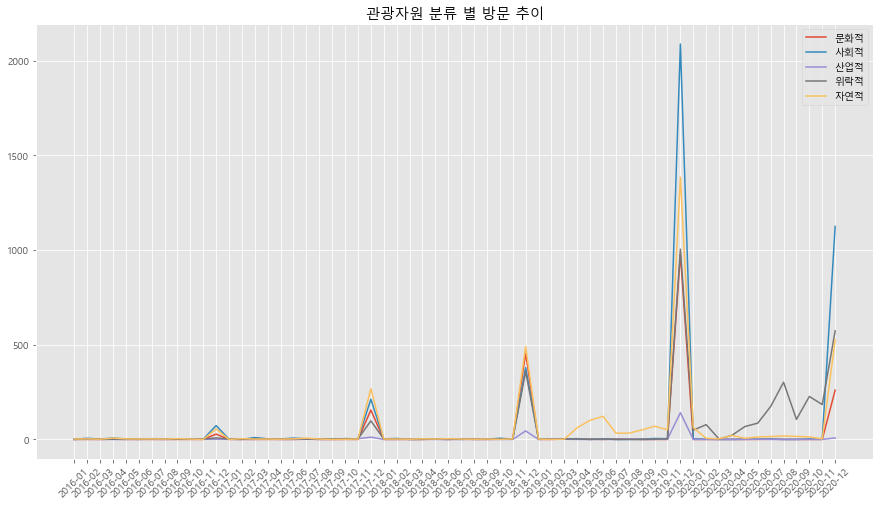

In [55]:
import matplotlib.pyplot as plt

#카테고리 별로 데이터 나누기
L_cul = pivot1.loc['문화적'].tolist()
L_soc = pivot1.loc['사회적'].tolist()
L_ind = pivot1.loc['산업적'].tolist()
L_ent = pivot1.loc['위락적'].tolist()
L_nat = pivot1.loc['자연적'].tolist()

plt.style.use('ggplot')
plt.figure(figsize=(15, 8))
plt.rc('font', family='Malgun Gothic')
plt.title('관광자원 분류 별 방문 추이')

plt.plot(list(pivot1.columns.strftime("%Y-%m")), L_cul, label='문화적')
plt.plot(list(pivot1.columns.strftime("%Y-%m")), L_soc, label='사회적')
plt.plot(list(pivot1.columns.strftime("%Y-%m")), L_ind, label='산업적')
plt.plot(list(pivot1.columns.strftime("%Y-%m")), L_ent, label='위락적')
plt.plot(list(pivot1.columns.strftime("%Y-%m")), L_nat, label='자연적')

plt.xticks(list(pivot1.columns.strftime("%Y-%m")), rotation=45)

plt.legend()
plt.show()

# 관광자원 카테고리 별로 토픽모델링?
아무래도 동성로 토픽이랑 앞산 토픽은 다를테니까